In [1]:
import torch
import json
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Noise

import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask

## Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/HD22049_310_0100_C-0656_A_.hdf5",
                  data_tag="object",
                  psf_template_tag="psf_template",
                  para_tag="header_object/PARANG")

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
science_data = science_data[:, 12:-12, 12:-12]

## Init function of S4 Noise

In [4]:
s4_noise_model = S4Noise(
    data_image_size=science_data.shape[1],
    psf_template=psf_template_data,
    lambda_reg=2000,
    cut_radius_psf=4.0,
    mask_template_setup=("radius", 5.5),
    normalization="normal",
    convolve=True,
    verbose=True)

Creating right reason mask ... [DONE]


# Prepare the data

In [5]:
science_data_torch = torch.from_numpy(science_data)

In [6]:
s4_noise_model._prepare_normalization(science_data_torch)
science_data_norm = s4_noise_model.normalize_data(science_data_torch)

Build normalization frames ... [DONE]


## Implement the current math for a single position

In [15]:
half_precision = False
device = 0
positions = [(40, 40), (40, 60), (45, 30), (54, 54)][:2]
lambda_reg = s4_noise_model.lambda_reg
verbose=True

In [23]:
# get all the data we need as pytroch tensors
X_torch = science_data_norm.float()
p_torch = s4_noise_model.psf_model.float()
M_torch = s4_noise_model.right_reason_mask.float()# == 1

# 1. Convolve

In [24]:
X_torch = X_torch.unsqueeze(1)
image_size = X_torch.shape[-1]

# convolve the data on the GPU
X_torch = X_torch.to(device)

if p_torch is not None:
    X_conv = F.conv2d(
        X_torch,
        p_torch.to(device),
        padding="same").float()
else:
    X_conv = X_torch.to(device)

X_torch = X_torch.cpu()
X_conv = X_conv.view(X_torch.shape[0], -1)

## Function to convolve the weights

In [25]:
def compute_betas(
    betas_raw,
    image_size,
    right_reason_mask,
    psf_model):
    
    # reshape the raw betas
    raw_betas = betas_raw.view(
        -1,
        image_size,
        image_size)

    # set regularization_mask values to zero
    tmp_weights = raw_betas * right_reason_mask

    # convolve the weights
    tmp_weights = F.conv2d(
        tmp_weights.unsqueeze(1),
        psf_model,
        padding="same").view(
        raw_betas.shape[0],
        image_size,
        image_size)

    return tmp_weights

# 2. Compute Beta LSTR

In [26]:
# Compute the multiplication in double precision.
# Float32 can cause numerical instability.
X_conv_square = (X_conv.T.double() @ X_conv.double()).float()

In [27]:
tmp_idx = positions[0][0] * image_size + positions[0][1]

In [30]:
m_torch = M_torch[tmp_idx].flatten().to(device)

lhs = ((X_conv_square * m_torch).T * m_torch).T + \
      torch.eye(
          image_size ** 2,
          image_size ** 2,
          device=X_conv_square.device) * lambda_reg * 1000

In [31]:
torch.linalg.cond(lhs)

tensor(31211.2969, device='cuda:0')

In [22]:
torch.linalg.cond(lhs)

tensor(2.1878e+10, device='cuda:0')

In [ ]:
# Compute all betas in a loop over all positions
betas = []
mask_sel = []

tmp_iter = positions
if verbose:
    tmp_iter = tqdm(positions)

for x, y in tmp_iter:
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten().to(device)
    mask_sel.append(m_torch.cpu())
    
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx].to(device)

    # set up the least square problem
    lhs = ((X_conv_square * m_torch).T * m_torch).T + \
          torch.eye(
              image_size ** 2,
              image_size ** 2,
              device=X_conv_square.device) * lambda_reg

    # compute beta
    rhs = (X_conv * m_torch).T @ Y_torch
    beta = torch.linalg.lstsq(
        lhs.cpu(),
        rhs.view(-1, 1).cpu(),
    ).solution.squeeze()

    betas.append(beta)

# We move the beta matrix to the device of the noise model (usually cpu)
betas_final = torch.stack(betas).reshape(
    len(betas), image_size**2).cpu()

mask_final = torch.stack(mask_sel).reshape(
    len(betas), image_size, image_size).cpu().float()

  0%|                                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

In [ ]:
betas_lstsq2 = compute_betas(
    betas_final, 
    image_size,
    mask_final,
    s4_noise_model.psf_model.float()
)

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(2, 2, 1)
im1 = ax1.imshow(torch.abs(betas_lstsq2)[0])
fig.colorbar(im1)

ax2 = plt.subplot(2, 2, 2)
im2 = ax2.imshow(torch.abs(betas_lstsq)[0])
fig.colorbar(im2)

ax3 = plt.subplot(2, 2, 3)
im3 = ax3.imshow(torch.abs(betas_lstsq[0] - betas_lstsq2[0]))
fig.colorbar(im3)

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(torch.abs(betas_lstsq[1] - betas_lstsq2[1]))

plt.tight_layout()

# Using QR decomposition

In [30]:
# get all the data we need as pytroch tensors
X_torch = science_data_norm.float()
p_torch = s4_noise_model.psf_model.float()
M_torch = s4_noise_model.right_reason_mask.float()

In [31]:
X_torch = X_torch.unsqueeze(1)
image_size = X_torch.shape[-1]

# convolve the data on the GPU
X_torch = X_torch.to(device)

if p_torch is not None:
    X_conv = F.conv2d(
        X_torch,
        p_torch.to(device),
        padding="same")
else:
    X_conv = X_torch.to(device)

X_torch = X_torch.cpu()
X_conv = X_conv.view(X_torch.shape[0], -1)

In [32]:
# Compute all betas in a loop over all positions
betas = []
mask_sel = []

tmp_iter = positions
if verbose:
    tmp_iter = tqdm(positions)

for x, y in tmp_iter:
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten().to(device)
    mask_sel.append(m_torch.cpu())
    
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx].to(device)
    
    eye = torch.eye(image_size**2, image_size**2, device=device) * np.sqrt(lambda_reg)

    X_conv_cut = X_conv * m_torch
    B = torch.concat([X_conv_cut, eye])
    Y_torch_new = torch.concat([
        Y_torch, 
        torch.zeros(image_size**2, device=device)])
    
    # run QR decomposition
    Q, R = torch.linalg.qr(B, mode="reduced")
    
    rhs = Q.T @ Y_torch_new
    beta = torch.linalg.solve_triangular(
        R, rhs.view(-1, 1), upper=True)#.squeeze()

    betas.append(beta)

# We move the beta matrix to the device of the noise model (usually cpu)
betas_final = torch.stack(betas).reshape(
    len(betas), image_size**2).cpu()

mask_final = torch.stack(mask_sel).reshape(
    len(betas), image_size, image_size).cpu().float()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.69s/it]


In [33]:
betas_qr = compute_betas(
    betas_final, 
    image_size,
    mask_final,
    s4_noise_model.psf_model.float()
)

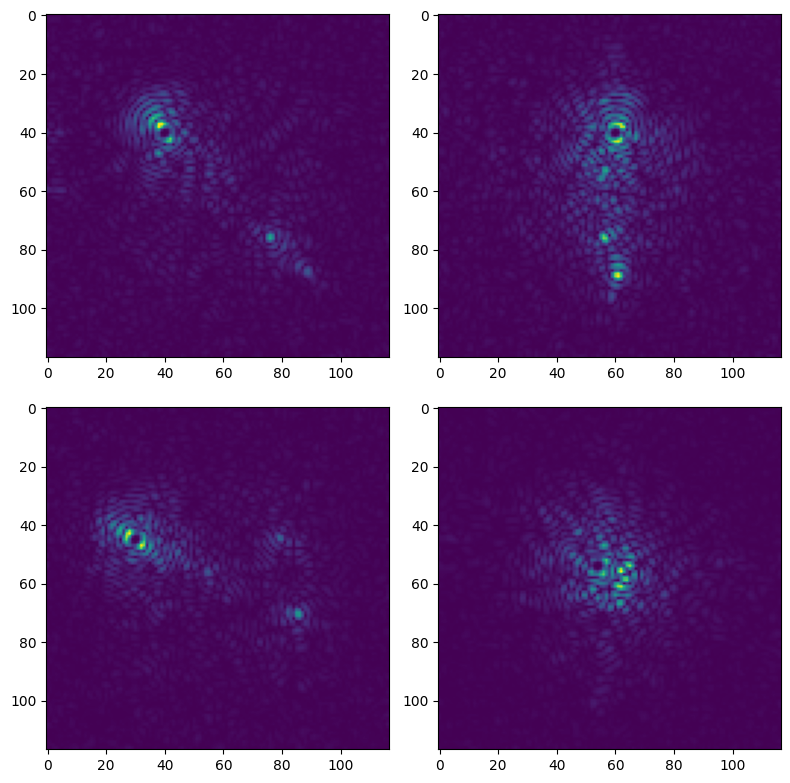

In [34]:
plt.figure(figsize=(8, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.imshow(torch.abs(betas_qr)[0])

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(torch.abs(betas_qr)[1])

ax3 = plt.subplot(2, 2, 3)
ax3.imshow(torch.abs(betas_qr)[2])

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(torch.abs(betas_qr)[3])

plt.tight_layout()

# QR decomposition with torch

In [35]:
# get all the data we need as pytroch tensors
X_torch = science_data_norm.float()
p_torch = s4_noise_model.psf_model.float()
M_torch = s4_noise_model.right_reason_mask.float()

In [36]:
X_torch = X_torch.unsqueeze(1)
image_size = X_torch.shape[-1]

# convolve the data on the GPU
X_torch = X_torch.to(device)

if p_torch is not None:
    X_conv = F.conv2d(
        X_torch,
        p_torch.to(device),
        padding="same")
else:
    X_conv = X_torch.to(device)

X_torch = X_torch.cpu()
X_conv = X_conv.view(X_torch.shape[0], -1)

In [37]:
# Compute all betas in a loop over all positions
betas = []
mask_sel = []

tmp_iter = positions
if verbose:
    tmp_iter = tqdm(positions)

for x, y in tmp_iter:
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten().to(device)
    mask_sel.append(m_torch.cpu())
    
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx].to(device)
    
    eye = torch.eye(image_size**2, image_size**2, device=device) * np.sqrt(lambda_reg)

    X_conv_cut = X_conv * m_torch
    B = torch.concat([X_conv_cut, eye])
    Y_torch_new = torch.concat([
        Y_torch, 
        torch.zeros(image_size**2, device=device)])
    
    beta = torch.linalg.lstsq(B, Y_torch_new.view(-1, 1)).solution.squeeze()

    betas.append(beta)

# We move the beta matrix to the device of the noise model (usually cpu)
betas_final = torch.stack(betas).reshape(
    len(betas), image_size**2).cpu()

mask_final = torch.stack(mask_sel).reshape(
    len(betas), image_size, image_size).cpu().float()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.52s/it]


In [38]:
betas_qr2 = compute_betas(
    betas_final, 
    image_size,
    mask_final,
    s4_noise_model.psf_model.float()
)

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(2, 2, 1)
im1=ax1.imshow(torch.abs(betas_qr2-betas_lstsq)[2])
fig.colorbar(im1)

ax2 = plt.subplot(2, 2, 2)
im2=ax2.imshow(torch.abs(betas_lstsq)[1])
fig.colorbar(im2)

ax3 = plt.subplot(2, 2, 3)
im3=ax3.imshow(torch.abs(betas_qr2-betas_lstsq)[3])
fig.colorbar(im3)

ax4 = plt.subplot(2, 2, 4)
im4=ax4.imshow(torch.abs(betas_lstsq)[0])
fig.colorbar(im4)

plt.tight_layout()

# Speed of QR update

In [24]:
from scipy.linalg import qr_delete

In [26]:
Q_cpu = Q.cpu()
R_cpu = R.cpu()

In [27]:
qr_delete(Q_cpu, R_cpu, 200, 3)

(array([[-1.1954854e-02,  3.2289836e-04,  2.4067054e-03, ...,
         -2.2831076e-04, -4.3211205e-04, -7.7598204e-05],
        [-1.1663384e-02, -1.8991379e-03,  1.1174814e-03, ...,
         -2.5491479e-03, -1.1578628e-03,  3.6915435e-04],
        [-1.1759934e-02, -1.7299401e-03, -5.3035235e-04, ...,
         -1.3472574e-03, -1.7994927e-03,  1.2728925e-03],
        ...,
        [-6.8978986e-13, -4.2535462e-15, -1.2273631e-13, ...,
          7.2469538e-01, -3.5154077e-01,  5.1074121e-02],
        [ 1.3856589e-13, -1.4915479e-13,  1.7530607e-13, ...,
          7.0745723e-14,  7.2673154e-01,  3.5458717e-01],
        [ 9.1336959e-14, -7.0710873e-14,  5.5615790e-14, ...,
          4.6076244e-14,  1.4578218e-14, -7.0813364e-01]], dtype=float32),
 array([[-1007.9223  , -1281.8661  , -1347.5842  , ...,  -430.4592  ,
          -377.3479  ,  -287.21866 ],
        [    0.      ,   256.1199  ,   510.8691  , ...,   135.76872 ,
           117.85705 ,    88.8837  ],
        [    0.      ,     0.     